## Description
I found this dataset on https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data and thought it would make for good practice with time series data.

The data has the temperature, humidity, wind_speed, and mean pressulre for every day in Delhi from to 2013 to April of 2017. The goal will be to predict 2017 given the previous few years to learn some patterns.

Though the data has a training and test set, I'm actually going to just use the training set file and try to predict into the future. So the "test" file is actually a stand in for real data outside of the training, and the test set I'll use to train the network will be a subset of the "train" file. We'll use a rolling forecast, where each training step will take the last 10 days and predict the next day's temperature.


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.regularizers import l2
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices('GPU'))

/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-17 17:10:26.370217: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-17 17:10:26.370241: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-17 17:10:26.370245: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-17 17:10:26.370272: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-17 17:10:26.370284: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
train=pd.read_csv('../data/Delhi_weather/DailyDelhiClimateTrain.csv')
test=pd.read_csv('../data/Delhi_weather/DailyDelhiClimateTest.csv')
start_df = train.drop(train.tail(1).index) #noticed the last entry here is dummy. drop it.
start_df.tail()
test.loc[0,'meanpressure']=train['meanpressure'].iloc[-1]


## Feature engineering
The trends may be capturable with some simple feature engineering. Let's include information from yearly seasons, moving averages, and yesterday's value.

In [3]:


def add_features(init_df):
    #clean up unphysical values
    mean_pressure = init_df['meanpressure'][(init_df['meanpressure'] >= 980) & (init_df['meanpressure'] <= 1200)].mean()
    init_df['meanpressure'] = init_df['meanpressure'].apply(lambda x: mean_pressure if x < 980 or x > 1200 else x)
    #replace date with days since start
    init_df['days_since_start'] = (pd.to_datetime(init_df['date'])-pd.to_datetime(init_df['date'][0])).dt.days
    cols = ['days_since_start'] + [col for col in init_df.columns if col != 'days_since_start']
    train = init_df.copy()[cols]
    train.drop('date', axis=1, inplace=True)
    window_size = 3
    for quantity in ['meantemp','humidity','wind_speed','meanpressure']:
        #add a rolling average
        train[quantity+'_rolling'] = train[quantity].rolling(window=window_size).mean()
    #add Fourier phases as a feature
    T = 365
    K = 4
    for k in range(1, K + 1):
        train['sin' + str(k)] = np.sin(2 * np.pi * k * train.days_since_start / T)
        train['cos' + str(k)] = np.cos(2 * np.pi * k * train.days_since_start / T)
        
        
    train=train.fillna(method='bfill')
    return train

train=add_features(start_df)


### Create a model



In [4]:
#we will train on 10 days, then predict the 11th

# Separate features and target
features = train.iloc[:-1]
target = train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].shift(-1).iloc[:-1]


# Normalize the features using StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


target_scaler = StandardScaler()
targets_scaled = target_scaler.fit_transform(target.values.reshape(-1, 4))

# Create sequences for LSTM
time_steps = 10
X, y = [], []

for i in range(len(features_scaled) - time_steps):
    X.append(features_scaled[i:i+time_steps])
    y.append(targets_scaled[i-1+time_steps])
    
X = np.array(X)
n_features=X.shape[2]
y = np.array(y)
print(np.shape(X))
print(np.shape(y))


(1450, 10, 17)
(1450, 4)


### Training

In [5]:

model = Sequential([
    Dense(64,input_shape=(X.shape[1], X.shape[2])), #I find these layers help map relationships between features
    Dropout(0.2),
    Dense(64,input_shape=(X.shape[1], X.shape[2])), 
    Dropout(0.2),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)), # Regularization and dropout to prevent overfitting
    Dropout(0.2),
    LSTM(32,return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    LSTM(16),
    Dense(np.shape(y)[1]) # Output layer with units predicting the y values
])

model.compile(optimizer='adam', loss='mse')
history=model.fit(X, y, epochs=200, verbose=0)


2023-08-17 17:10:26.414814: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-17 17:10:26.414835: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-08-17 17:10:27.960823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-17 17:10:28.213424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-17 17:10:28.261092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-17 17:10:28.30

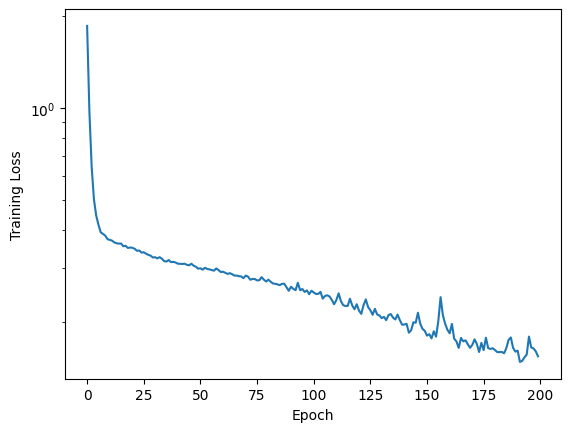

In [6]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.yscale('log')
plt.show()

In [7]:
#function that takes test data, evaluates features of last 10 days, predicts next day

#the tricky part is that the first day of the test requires the previous days from the training. Solve this by appending these days
last_10_days=start_df.tail(13)
evaluate_df = pd.concat([last_10_days, test], ignore_index=True)
#evaluate same features:
def add_features_test(init_df):
    #clean up unphysical values
    mean_pressure = init_df['meanpressure'][(init_df['meanpressure'] >= 980) & (init_df['meanpressure'] <= 1200)].mean()
    init_df['meanpressure'] = init_df['meanpressure'].apply(lambda x: mean_pressure if x < 980 or x > 1200 else x)

    init_df['days_since_start'] = (pd.to_datetime(init_df['date'])-pd.to_datetime(start_df['date'][0])).dt.days
    cols = ['days_since_start'] + [col for col in init_df.columns if col != 'days_since_start']
    test = init_df.copy()[cols]
    test.drop('date', axis=1, inplace=True)
    window_size = 3
    for quantity in ['meantemp','humidity','wind_speed','meanpressure']:
        #add a rolling average
        test[quantity+'_rolling'] = test[quantity].rolling(window=window_size).mean()
    #add Fourier phases as a feature
    T = 365
    K = 4
    for k in range(1, K + 1):
        test['sin' + str(k)] = np.sin(2 * np.pi * k * test.days_since_start / T)
        test['cos' + str(k)] = np.cos(2 * np.pi * k * test.days_since_start / T)
    test=test.fillna(method='bfill')
    return test
evaluate_df=add_features_test(evaluate_df)



2023-08-17 17:13:30.427071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-17 17:13:30.518745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-17 17:13:30.551388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-17 17:13:30.580988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


MSE: 0.34255892751551636


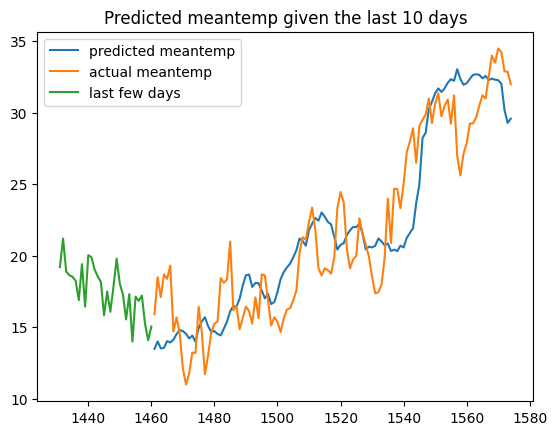

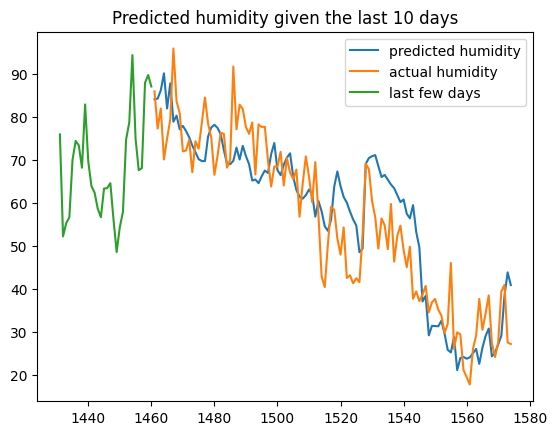

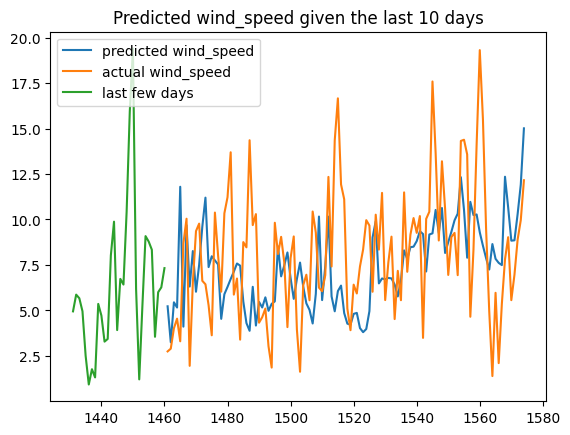

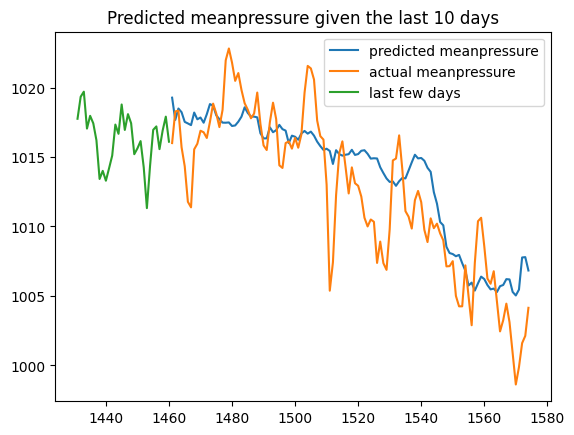

In [8]:
def predict_next_day(df):
    X_test=scaler.transform(df)
    X_test = np.array(X_test).reshape(-1, 10, n_features)
    y=model.predict(X_test,verbose=0)
    return target_scaler.inverse_transform(y)

predictions=[]
actuals=[]
predicted_day=[]
for index_to_check in range(13,len(evaluate_df)):
    predictions.append(predict_next_day(evaluate_df.iloc[index_to_check-10:index_to_check]))
    actuals.append(evaluate_df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].iloc[index_to_check])
    predicted_day.append(evaluate_df['days_since_start'].iloc[index_to_check])
predictions=np.array(predictions).squeeze()
actuals=np.array(actuals)
print('MSE:' , np.mean((target_scaler.transform(predictions)-target_scaler.transform(actuals))**2))
for i, quality in enumerate(['meantemp', 'humidity', 'wind_speed', 'meanpressure']):
    plt.plot(predicted_day,predictions[:,i],label='predicted '+quality)
    plt.plot(predicted_day,actuals[:,i],label='actual '+quality)
    plt.plot(train['days_since_start'].iloc[-30:],train[quality].iloc[-30:],label='last few days')
    plt.legend()
    plt.title('Predicted '+quality+' given the last 10 days')
    plt.show()


## What about if we only are given the last 10 days of the year?

In [9]:
def update_df(df, predictions, index_to_update):
    window_size = 3
    for quant_i, quantity in enumerate(['meantemp','humidity','wind_speed','meanpressure']):
        #update value
        df.loc[index_to_update,quantity]=np.array(predictions)[index_to_update-1,quant_i]
        # update rolling average
        # df[quantity+'_rolling'].iloc[index_to_update] = df[quantity].iloc[index_to_update+1-window_size:index_to_update+1].mean()
        mean_value = df.loc[index_to_update+1-window_size:index_to_update+1, quantity].mean()
        df.loc[index_to_update, quantity + '_rolling'] = mean_value
    T = 365
    K = 4
    for k in range(1, K + 1):
        df['sin' + str(k)] = np.sin(2 * np.pi * k * df['days_since_start'] / T)
        df['cos' + str(k)] = np.cos(2 * np.pi * k * df['days_since_start'] / T)
        # update detrended values
        # df.loc[index_to_update, quantity + '_detrended'] = df.loc[index_to_update, quantity] - df.loc[index_to_update, quantity + '_trend']    # return df


MSE: 0.7817394240468815


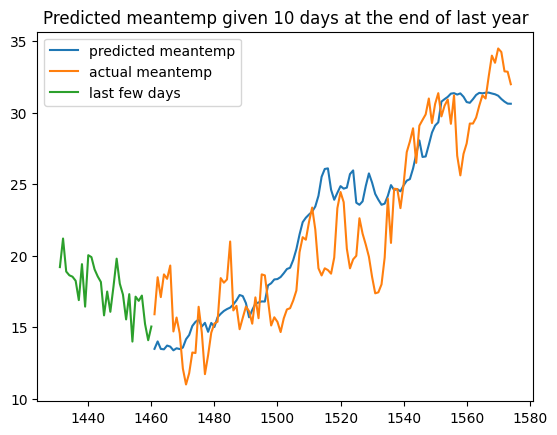

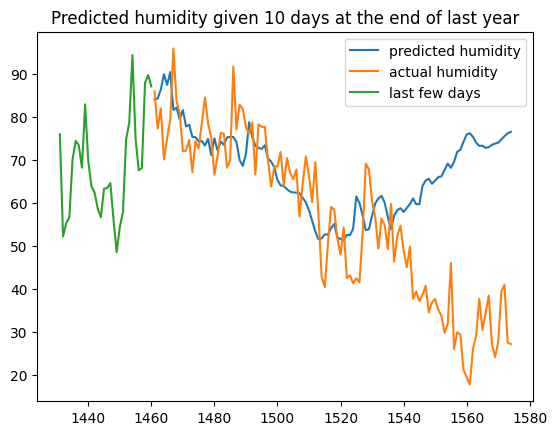

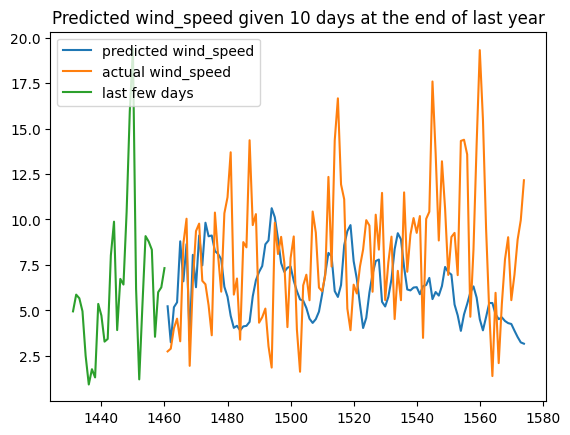

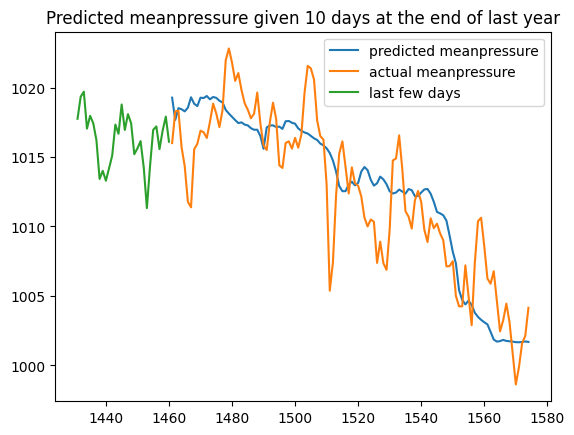

In [10]:
future_df=evaluate_df.copy()
predictions=[]
actuals=[]
predicted_day=[]
future_day=[1460]
for index_to_check in range(0,13):
    predictions.append(np.array([np.nan,np.nan,np.nan,np.nan]))
    actuals.append(np.array([np.nan,np.nan,np.nan,np.nan]))

for index_to_check in range(13,len(evaluate_df)): #this loop can only go to the end of the df
    actuals.append(evaluate_df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].iloc[index_to_check])
    predicted_day.append(evaluate_df['days_since_start'].iloc[index_to_check])
    predictions.append(predict_next_day(future_df.iloc[index_to_check-10:index_to_check]).squeeze())
    future_day.append(future_day[index_to_check-13]+1)
    future_df.loc[index_to_check,'days_since_start'] = future_day[-1]
    update_df(future_df,predictions, index_to_check+1)

future_day=future_day[1:] #makes future_day start from the same place as predicted_day
predictions=np.array(predictions).squeeze()
actuals=np.array(actuals)
print('MSE:' , np.mean((target_scaler.transform(predictions[13:])-target_scaler.transform(actuals[13:]))**2))
for i, quality in enumerate(['meantemp', 'humidity', 'wind_speed', 'meanpressure']):
    plt.plot(future_day,predictions[13:,i],label='predicted '+quality)
    plt.plot(predicted_day,actuals[13:,i],label='actual '+quality)
    plt.plot(train['days_since_start'].iloc[-30:],train[quality].iloc[-30:],label='last few days')
    # print(quality +' error:' , np.sqrt(np.mean(predictions[13:,i]-actuals[13:,i])**2))
    plt.legend()
    plt.title('Predicted '+quality+' given 10 days at the end of last year')
    plt.show()

## Growing Errors into the Future

Just out of curiosity, what if we continue to extrapolate, propagating errors into the future?


In [11]:
future_df=evaluate_df.copy()
predictions=[]
actuals=[]
predicted_day=[]
future_day=[1460]
for index_to_check in range(0,13):
    predictions.append(np.array([np.nan,np.nan,np.nan,np.nan]))
    actuals.append(np.array([np.nan,np.nan,np.nan,np.nan]))

for index_to_check in range(13,len(evaluate_df)): #this loop can only go to the end of the df
    actuals.append(evaluate_df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].iloc[index_to_check])
    predicted_day.append(evaluate_df['days_since_start'].iloc[index_to_check])
    predictions.append(predict_next_day(future_df.iloc[index_to_check-10:index_to_check]).squeeze())
    future_day.append(future_day[index_to_check-13]+1)
    future_df.loc[index_to_check,'days_since_start'] = future_day[-1]
    update_df(future_df,predictions, index_to_check+1)
for index_to_check in range(len(evaluate_df),2500): #this loop can go as long as you want
    prediction=predict_next_day(future_df.iloc[index_to_check-10:index_to_check]).squeeze()
    predictions.append(prediction)
    future_day.append(future_day[index_to_check-13]+1)
    future_df.loc[index_to_check,'days_since_start'] = future_day[-1]
    update_df(future_df,predictions, index_to_check+1)

future_day=future_day[1:] #makes future_day start from the same place as predicted_day
predictions=np.array(predictions).squeeze()
actuals=np.array(actuals)

3880


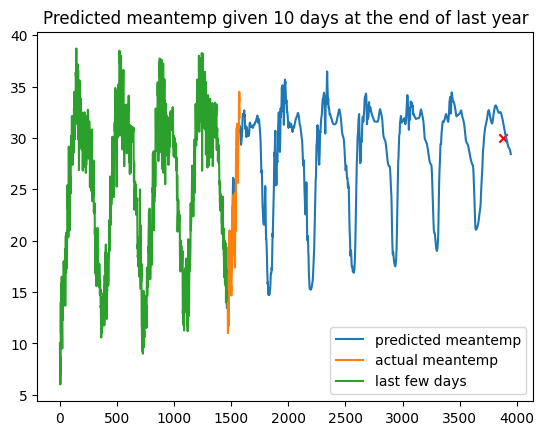

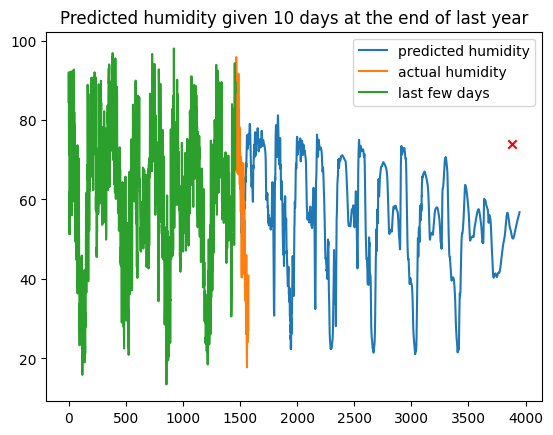

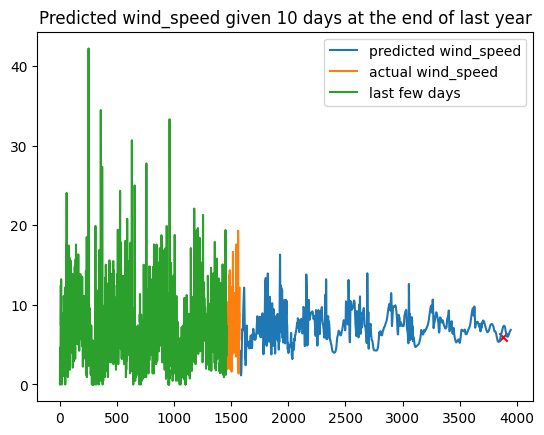

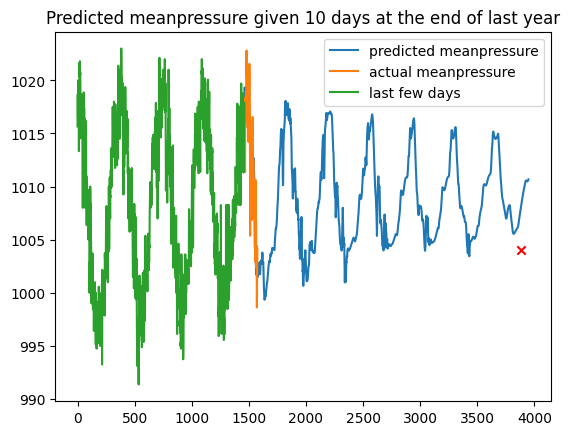

In [12]:
init_df=pd.read_csv('../data/Delhi_weather/DailyDelhiClimateTrain.csv')
today='2023-08-17'
days_since_start=(pd.to_datetime(today)-pd.to_datetime(init_df['date'][0])).days
print(days_since_start)
weather_today=[30, 74, 6, 1004] 
for i, quality in enumerate(['meantemp', 'humidity', 'wind_speed', 'meanpressure']):

    plt.scatter(days_since_start, weather_today[i], marker='x',c='r') #it was 30 today in Delhi.
    plt.plot(future_day,predictions[13:,i],label='predicted '+quality)
    plt.plot(predicted_day,actuals[13:,i],label='actual '+quality)
    plt.plot(train['days_since_start'].iloc[:],train[quality].iloc[:],label='last few days')
    # print(quality +' error:' , np.sqrt(np.mean(predictions[13:,i]-actuals[13:,i])**2))
    plt.legend()
    plt.title('Predicted '+quality+' given 10 days at the end of last year')
    plt.show()


Not too bad, considering we've gone way past the training data. Looks like when trying to extrapolate so far out, our model lost some of its amplitude for the periodicity. I suspect that it doesn't like to predict outlier events, hedging its bets. Then when it loads its last 10 predictions, they're all more temperate, leading to overall reduced swings compared to reality.